**Predicting FIFA 2018 Winner**

 **Method**:
- Use data from Kaggle to model the outcome of certain pairings between teams, given their rank, points, and the weighted point difference with the opponent.
- Use this model to predict the outcome of the group rounds and then the single-elimination phase
- Compare results with the countries' talent scores

The analysis can be split into 3 portions:

* Firstly, we will use logistic regression to predict which countries make it to the single elimination round, and subsequently win the world cup.
>(Reference to [Dr. James Bond's predictive model](https://www.kaggle.com/agostontorok/soccer-world-cup-2018-winner))
* Secondly, we will use the talent scores of countries to better support the results of the finals matchup.
* Thirdly, we will predict the actual scores of the finals matchup and 2nd runner up matchup.

**Predicted FIFA 2018 winner : Germany**

***Takeaways:***

Overlaying the output with the matchup predictions, we have 3 key observations:
1.  The logistic regression model coupled with the talent visualization shows that of the 16 top overall talent countries,   11/16 of countries will make it through to the single elimination rounds. 
> While this is inconclusive, it does give an indication that the talent pool available is probably an important factor to a country's perfomance at FIFA. 
> The format of FIFA ensures that not all 16 of the top talent pool countries will make it through to the elimination stages with ease, there are multiple points of upset even before FIFA begins. For example, Italy was previously ousted due to losing to Sweden in the 2nd round playoff in Nov 2017, despite having one of the best talents.
2. There are multiple matches with almost 50/50 chance for either side to win, this implies that the model is unable to predict with high confidence of some matchups and will need to be tweaked as the results unfold. **(this is what makes it interesting to watch isn't it)**,
> In the quarterfinals matchup, Argentina vs Portugal, only 1 team will make it to the finals with the top 2 players by overall ratings (Ronaldo & Messi) leading on each side. Interestingly, the winning chances of Portugal is only by 0.01.
3. In the Finals matchup between Belgium and Germany, there is a substantially higher overall talent score for Germany (82.58) as compared to Belgium(79.2), even if Belgium were to maximize it's potential, it will only hit a score of 81.7 (which is still below Germany's overall score). Hence, unless there is significant environmental influence, both the predictive model & talent assessment results indicate Germany as the champions of FIFA 2018.

**Data Used**

I used 4 datasets
- FIFA rankings from 1993 to 2018 (courtesy of [Tadhg Fitzgerald](https://www.kaggle.com/tadhgfitzgerald) 
> This one I used to get the FIFA ranking and points for the teams, which is a monthly changing rank previously shown as a [decent predictor](http://www.sportingintelligence.com/2014/06/20/upsets-giant-killings-adios-bye-bye-fifa-rankings-still-ahead-in-predicting-results-200601/) of team performance
- International Soccer matches from 1872 to 2018 (courtesy of [Mart Jürisoo](https://www.kaggle.com/martj42))
> This I will use to find out how much the difference in point, ranks and the current rank of the team affects the outocme of a match
- FIFA World Cup 2018 data set (courtesy of [Nuggs](https://www.kaggle.com/ahmedelnaggar))
> This I will use to get the upcoming matches 
- Complete FIFA 2017 Player dataset (Global) (https://www.kaggle.com/artimous/complete-fifa-2017-player-dataset-global)
> Aggregating countries top players value & strength

In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

rankings = pd.read_csv('/Users/soonleqi/Downloads/fifa_ranking.csv')
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]
rankings = rankings.replace({"IR Iran": "Iran"})
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

matches = pd.read_csv('/Users/soonleqi/Downloads/results.csv')
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])

world_cup = pd.read_csv('/Users/soonleqi/Downloads/World Cup 2018 Dataset.csv')
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]
world_cup = world_cup.dropna(how='all')
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
world_cup = world_cup.set_index('Team')

**Feature Extraction**

Rank data are combined with the day matches are played:

Then extract some features:
- Point and rank differences
- Friendly matches are removed, assumption being friendly is not reflective of final results in fifa, which is competitive in nature.

In [26]:
# I want to have the ranks for every day 
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# join the ranks
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

In [27]:
# feature generation
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_stake'] = matches['tournament'] != 'Friendly'
matches['is_won'] = matches['score_difference'] > 0 # take draw as lost

# I tried earlier rest days but it did not turn to be useful
max_rest = 30
matches['rest_days'] = matches.groupby('home_team').diff()['date'].dt.days.clip(0,max_rest).fillna(max_rest)

# I tried earlier the team as well but that did not make a difference either
matches['wc_participant'] = matches['home_team'] * matches['home_team'].isin(world_cup.index.tolist())
matches['wc_participant'] = matches['wc_participant'].replace({'':'Other'})
matches = matches.join(pd.get_dummies(matches['wc_participant']))

**Modelling**

I used a Simple Logistic regression (Accuracy = 68.18%)

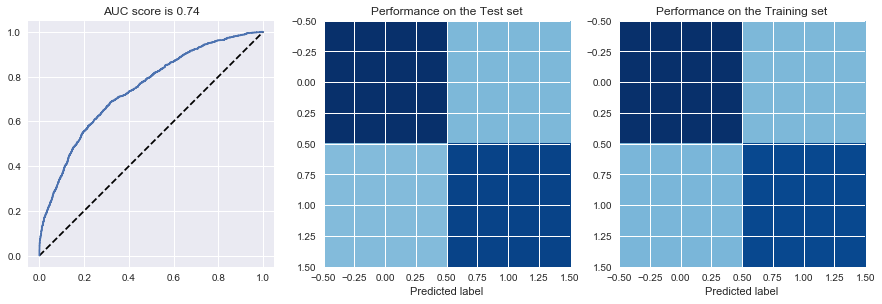

In [28]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = matches.loc[:,['rank_home', 'rank_difference', 'point_difference', 'is_stake']], matches['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logreg = linear_model.LogisticRegression(C=1e-5)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
model = model.fit(X_train, y_train)

# figures 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')
pass

With an accuracy level of 68.18%, the model is decent especially since soccer is a team sport and has a low score per game as compared to sports such as NBA -- which means it's much harder to have a good prediction of win loss outcome when game point differences are marginal.

# World Cup simulation

## Group rounds

In [29]:
# let's define a small margin when we safer to predict draw then win
margin = 0.05

# let's define the rankings at the time of the World Cup
world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])

In [30]:
from itertools import combinations

world_cup['points'] = 0
world_cup['total_prob'] = 0

for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))
    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        # entering the rank_home value using loc to search ranking
        row['rank_home'] = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        # Computing difference in ranking
        row['rank_difference'] = row['rank_home'] - opp_rank
        row['point_difference'] = home_points - opp_points
        
        home_win_prob = model.predict_proba(row)[:,1][0]
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        
        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            # Establishing the 'points' column here
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1

___Starting group G:___
Belgium vs. Panama: Belgium wins with 0.73
Belgium vs. Tunisia: Belgium wins with 0.61
Belgium vs. England: Belgium wins with 0.57
Panama vs. Tunisia: Tunisia wins with 0.73
Panama vs. England: England wins with 0.77
Tunisia vs. England: England wins with 0.57
___Starting group B:___
Portugal vs. Spain: Draw
Portugal vs. Morocco: Portugal wins with 0.68
Portugal vs. Iran: Portugal wins with 0.66
Spain vs. Morocco: Spain wins with 0.65
Spain vs. Iran: Spain wins with 0.64
Morocco vs. Iran: Draw
___Starting group A:___
Russia vs. Saudi Arabia: Saudi Arabia wins with 0.55
Russia vs. Egypt: Egypt wins with 0.66
Russia vs. Uruguay: Uruguay wins with 0.83
Saudi Arabia vs. Egypt: Egypt wins with 0.65
Saudi Arabia vs. Uruguay: Uruguay wins with 0.83
Egypt vs. Uruguay: Uruguay wins with 0.74
___Starting group F:___
Germany vs. Mexico: Germany wins with 0.60
Germany vs. Sweden: Germany wins with 0.63
Germany vs. Korea Republic: Germany wins with 0.71
Mexico vs. Sweden: Dr

## Single-elimination rounds

In [31]:
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

labels = []
odds = []

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        row['rank_home'] = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['rank_difference'] = row['rank_home'] - opp_rank
        row['point_difference'] = home_points - opp_points

        home_win_prob = model.predict_proba(row)[:,1][0]
        if model.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

___Starting of the round_of_16___
Uruguay vs. Spain: Spain wins with probability 0.54
Denmark vs. Croatia: Denmark wins with probability 0.55
Brazil vs. Mexico: Brazil wins with probability 0.58
Belgium vs. Colombia: Belgium wins with probability 0.59
Egypt vs. Portugal: Portugal wins with probability 0.81
France vs. Argentina: Argentina wins with probability 0.53
Switzerland vs. Germany: Germany wins with probability 0.60
England vs. Poland: Poland wins with probability 0.53


___Starting of the quarterfinal___
Spain vs. Denmark: Denmark wins with probability 0.51
Brazil vs. Belgium: Belgium wins with probability 0.51
Portugal vs. Argentina: Portugal wins with probability 0.51
Germany vs. Poland: Germany wins with probability 0.57


___Starting of the semifinal___
Denmark vs. Belgium: Belgium wins with probability 0.57
Portugal vs. Germany: Germany wins with probability 0.56


___Starting of the final___
Belgium vs. Germany: Germany wins with probability 0.54




# 3rd place matchup 
Portugal wins with a chance of 0.55

In [32]:
row['rank_home'] = world_cup_rankings.loc['Denmark', 'rank']
home_points = world_cup_rankings.loc['Denmark', 'weighted_points']
opp_rank = world_cup_rankings.loc['Portugal', 'rank']
opp_points = world_cup_rankings.loc['Portugal', 'weighted_points']
# Computing difference in ranking
row['rank_difference'] = row['rank_home'] - opp_rank
row['point_difference'] = home_points - opp_points
Denmark_winning_prob = model.predict_proba(row)[:,1][0]
Portugal_winning_prob=1 -Denmark_winning_prob
Portugal_winning_prob

0.5551148734392013

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [34]:
df = pd.read_csv('/Users/soonleqi/Downloads/CompleteDataset.csv')
df.head()

/Users/soonleqi/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning:

Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.



,Unnamed: 0,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,0,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,1,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,93,93,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,2,Neymar,25,https://cdn.sofifa.org/48/18/players/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,94,Paris Saint-Germain,https://cdn.sofifa.org/24/18/teams/73.png,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,3,L. Suárez,30,https://cdn.sofifa.org/48/18/players/176580.png,Uruguay,https://cdn.sofifa.org/flags/60.png,92,92,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
4,4,M. Neuer,31,https://cdn.sofifa.org/48/18/players/167495.png,Germany,https://cdn.sofifa.org/flags/21.png,92,92,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**I will assume that the mean of the top 50 talents from each country rated by 'Overall' score is representative of the country's soccer capabilities at the world cup level**

In [35]:
df2 = df.sort_values(['Nationality','Overall'],ascending=False).groupby('Nationality').head(50)

In [36]:
def str2number(amount):
    if amount[-1] == 'M':
        return float(amount[1:-1])*1000000
    elif amount[-1] == 'K':
        return float(amount[1:-1])*1000
    else:
        return float(amount[1:])
    
df2['MaxPotential'] = df2['Potential'] - df2['Overall']
df2['ValueNum'] = df2['Value'].apply(lambda x: str2number(x))
top_teams = df2.groupby("Nationality").mean().sort_values("ValueNum", ascending=False).head(16).reset_index()[["Nationality", "Overall", "ValueNum",'MaxPotential']]

**Visualizing top 16 countries with the highest talent score**

In [37]:
trace1 = go.Bar(
    x = top_teams["Nationality"].tolist(),
    y = top_teams["Overall"].tolist(),
    name='Country Overall',
    marker=dict(
        color='rgba(55, 128, 191, 0.7)',
        line=dict(
            color='rgba(55, 128, 191, 1.0)',
            width=2,
        )
    )
)

trace2 = go.Bar(
    x = top_teams["Nationality"].tolist(),
    y = top_teams["MaxPotential"].tolist(),
    name='Country Potential',
    marker=dict(
        color='rgba(219, 64, 82, 0.7)',
        line=dict(
            color='rgba(219, 64, 82, 1.0)',
            width=2,
        )
    )
)

trace3 = go.Scatter(
    x = top_teams["Nationality"].tolist(),
    y = (top_teams["ValueNum"] / 1000000).tolist(),
    name='Country Value [M€]',
    mode = 'lines+markers',
    yaxis='y2'
)

data = [trace1, trace2,trace3]

layout = go.Layout(
    barmode='stack',
    title = 'Level of talent across countries',
    titlefont=dict(size=25),
    width=850,
    height=500,
    paper_bgcolor='rgb(244, 238, 225)',
    plot_bgcolor='rgb(244, 238, 225)',
    yaxis = dict(
        title= 'Country Overall/Potential',
        anchor = 'x',
        rangemode='tozero'
    ),
    xaxis = dict(title= 'Country Name'),
    yaxis2=dict(
        title='Country Value [M€]',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right',
        anchor = 'x',
        rangemode = 'tozero',
        dtick = 200
    ),
    #legend=dict(x=-.1, y=1.2)
    legend=dict(x=0.05, y=0.05)
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [38]:
# Countries identified by logreg to make it past group stages.
next_round_wc = world_cup.groupby('Group').nth([0, 1]) 
next_round_wc['Team']

Group
A        Uruguay
A          Egypt
B       Portugal
B          Spain
C        Denmark
C         France
D      Argentina
D        Croatia
E         Brazil
E    Switzerland
F        Germany
F         Mexico
G        Belgium
G        England
H         Poland
H       Colombia
Name: Team, dtype: object

In [39]:
# Overlaps
next_round_wc['Team'].isin(top_teams['Nationality']).agg('sum')

11

***Takeaways:***

Overlaying the output with the matchup predictions, we have 3 key observations:
1.  The logistic regression model coupled with the talent visualization shows that of the 16 top overall talent countries,   11/16 of countries will make it through to the single elimination rounds. 
> While this is inconclusive, it does give an indication that the talent pool available is probably an important factor to a country's perfomance at FIFA. 
> The format of FIFA ensures that not all 16 of the top talent pool countries will make it through to the elimination stages with ease, there are multiple points of upset even before FIFA begins. For example, Italy was previously ousted due to losing to Sweden in the 2nd round playoff in Nov 2017, despite having one of the best talents.
2. There are multiple matches with almost 50/50 chance for either side to win, this implies that the model is unable to predict with high confidence of some matchups and will need to be tweaked as the results unfold. **(this is what makes it interesting to watch isn't it)**,
> In the quarterfinals matchup, Argentina vs Portugal, only 1 team will make it to the finals with the top 2 players by overall ratings (Ronaldo & Messi) leading on each side. Interestingly, the winning chances of Portugal is only by 0.01.
3. In the Finals matchup between Belgium and Germany, there is a substantially higher overall talent score for Germany (82.58) as compared to Belgium(79.2), even if Belgium were to maximize it's potential, it will only hit a score of 81.7 (which is still below Germany's overall score). Hence, unless there is significant environmental influence, both the predictive model & talent assessment results indicate Germany as the champions of FIFA 2018.

In [40]:
# Extracting latest ranking for the top 4 countries in semifinals
finals = ['Germany','Portugal','Belgium','Denmark']
Lastest_rank_check = rankings.sort_values('rank_date', ascending = False).groupby('country_full').head(1)
Lastest_rank_check[Lastest_rank_check['country_full'].isin(finals)]

,rank_date,rank,country_full,country_abrv,cur_year_avg_weighted,two_year_ago_weighted,three_year_ago_weighted,weighted_points
477708,2018-06-07,12.0,Denmark,DEN,723.72,90.07,80.21,894.00
172857,2018-06-07,3.0,Belgium,BEL,629.98,158.94,186.58,975.50
1316012,2018-06-07,4.0,Portugal,POR,646.92,155.33,125.53,927.78
655647,2018-06-07,1.0,Germany,GER,775.06,127.28,240.15,1142.49


LightGBM predictions with K-Fold

In [41]:
# predictive model of away_score
list = ['rank_difference','is_stake','is_won','away_score']
df2 = matches[list]

In [42]:
# Importing the dataset
X2 = df2.iloc[:, 0:3]
y2 = df2.iloc[:, -1]

In [43]:
# creating dataset with index[0] > Denmark (Home) vs  Portugal (Away) & index[1] > Belgium (Home) vs Germany (Away)
df3 = pd.DataFrame(columns=["rank_difference", "is_stake",'is_won'], data=[[8,True,False],[2,True,False]])
df3

,rank_difference,is_stake,is_won
0,8,True,False
1,2,True,False


In [44]:
list = ['rank_difference','is_stake','is_won','home_score']
df6 = matches[list]

X3 = df6.iloc[:, 0:3]
y3 = df6.iloc[:, -1]

In [46]:
from sklearn.cross_validation import KFold
import lightgbm as lgb
import time

In [47]:
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 8,
    'num_leaves': 32,  # 63, 127, 255
    'feature_fraction': 0.8, # 0.1, 0.01
    'bagging_fraction': 0.8,
    'learning_rate': 0.01, #0.00625,#125,#0.025,#05,
    'verbose': 1
}

In [48]:
Y_target = []
for fold_id,(train_idx, val_idx) in enumerate(KFold(n=X2.shape[0], n_folds=5, random_state=1)):
    print('FOLD:',fold_id)
    X_train = X3.values[train_idx]
    y_train = y3.values[train_idx]
    X_valid = X3.values[val_idx]
    y_valid =  y3.values[val_idx]
    
    
    lgtrain = lgb.Dataset(X_train, y_train,
                feature_name=X3.columns.tolist(),
    #             categorical_feature = categorical
                         )

    lgvalid = lgb.Dataset(X_valid, y_valid,
                feature_name=X3.columns.tolist(),
    #             categorical_feature = categorical
                         )

    modelstart = time.time()
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=30000,
        valid_sets=[lgtrain, lgvalid],
        valid_names=['train','valid'],
        early_stopping_rounds=100,
        verbose_eval=100
    )
    
    test_pred = lgb_clf.predict(df3.values)
    Y_target.append(np.exp(test_pred)-1)
    print('fold finish after', time.time()-modelstart)

FOLD: 0
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.30821	valid's rmse: 1.32451
[200]	train's rmse: 1.23314	valid's rmse: 1.24844
[300]	train's rmse: 1.21604	valid's rmse: 1.23149
[400]	train's rmse: 1.21072	valid's rmse: 1.22656
[500]	train's rmse: 1.20862	valid's rmse: 1.2263
Early stopping, best iteration is:
[446]	train's rmse: 1.20956	valid's rmse: 1.22601
fold finish after 0.3735041618347168
FOLD: 1
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.23712	valid's rmse: 1.5965
[200]	train's rmse: 1.16113	valid's rmse: 1.51576
[300]	train's rmse: 1.14371	valid's rmse: 1.49421
[400]	train's rmse: 1.13828	valid's rmse: 1.4869
[500]	train's rmse: 1.13621	valid's rmse: 1.48519
[600]	train's rmse: 1.13524	valid's rmse: 1.48426
[700]	train's rmse: 1.13444	valid's rmse: 1.48406
[800]	train's rmse: 1.13388	valid's rmse: 1.48407
Early stopping, best iteration is:
[735]	train's rmse: 1.13424	valid's rmse: 1.48402
fold

In [49]:
Y_target2 = np.array(Y_target)
Y_target2= Y_target2.mean(axis=0)

In [50]:
Y_target = []
for fold_id,(train_idx, val_idx) in enumerate(KFold(n=X2.shape[0], n_folds=5, random_state=1)):
    print('FOLD:',fold_id)
    X_train = X2.values[train_idx]
    y_train = y2.values[train_idx]
    X_valid = X2.values[val_idx]
    y_valid =  y2.values[val_idx]
    
    
    lgtrain = lgb.Dataset(X_train, y_train,
                feature_name=X2.columns.tolist(),
    #             categorical_feature = categorical
                         )

    lgvalid = lgb.Dataset(X_valid, y_valid,
                feature_name=X2.columns.tolist(),
    #             categorical_feature = categorical
                         )

    modelstart = time.time()
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=30000,
        valid_sets=[lgtrain, lgvalid],
        valid_names=['train','valid'],
        early_stopping_rounds=100,
        verbose_eval=100
    )
    
    test_pred = lgb_clf.predict(df3.values)
    Y_target.append(np.exp(test_pred)-1)
    print('fold finish after', time.time()-modelstart)

FOLD: 0
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.08805	valid's rmse: 1.1253
[200]	train's rmse: 1.05092	valid's rmse: 1.09391
[300]	train's rmse: 1.04183	valid's rmse: 1.08797
[400]	train's rmse: 1.03855	valid's rmse: 1.08667
Early stopping, best iteration is:
[389]	train's rmse: 1.03881	valid's rmse: 1.08661
fold finish after 0.3161439895629883
FOLD: 1
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.0934	valid's rmse: 1.10119
[200]	train's rmse: 1.05592	valid's rmse: 1.07222
[300]	train's rmse: 1.04678	valid's rmse: 1.0673
[400]	train's rmse: 1.04346	valid's rmse: 1.06678
Early stopping, best iteration is:
[383]	train's rmse: 1.04385	valid's rmse: 1.06669
fold finish after 0.28539371490478516
FOLD: 2
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.07694	valid's rmse: 1.16525
[200]	train's rmse: 1.03986	valid's rmse: 1.13425
[300]	train's rmse: 1.03077	valid's rmse: 1.1

In [51]:
Y_target3 = np.array(Y_target)
Y_target3 = Y_target3.mean(axis=0)

In [53]:
away_score= pd.DataFrame(Y_target2, columns=['away_score']) 
home_score= pd.DataFrame(Y_target3, columns=['home_score'])
df8 = pd.DataFrame(columns=["Home","Away","rank_difference", "is_stake",'is_won'], data=[['Denmark', 'Portugal',8,True,False],['Belgium','Germany', 2,True,False]])
result2 = pd.concat([df8,away_score,home_score], axis=1)
result2

,Home,Away,rank_difference,is_stake,is_won,away_score,home_score
0,Denmark,Portugal,8,True,False,1.024212,3.414679
1,Belgium,Germany,2,True,False,0.994072,3.365196
